100%|██████████| 9912422/9912422 [00:02<00:00, 3423098.17it/s]


Extracting ./MNIST_data/MNIST/raw/train-images-idx3-ubyte.gz to ./MNIST_data/MNIST/raw



100%|██████████| 28881/28881 [00:00<00:00, 2033877.23it/s]

Extracting ./MNIST_data/MNIST/raw/train-labels-idx1-ubyte.gz to ./MNIST_data/MNIST/raw



100%|██████████| 1648877/1648877 [00:00<00:00, 3574771.00it/s]


Extracting ./MNIST_data/MNIST/raw/t10k-images-idx3-ubyte.gz to ./MNIST_data/MNIST/raw



100%|██████████| 4542/4542 [00:00<00:00, 6870006.77it/s]


Extracting ./MNIST_data/MNIST/raw/t10k-labels-idx1-ubyte.gz to ./MNIST_data/MNIST/raw

Initialized Network:
Size of net(1).w = 100x784
Size of net(1).b = 100
Size of net(4).w = 50x100
Size of net(4).b = 50
Size of net(7).w = 10x50
Size of net(7).b = 10
Size of net(10).w = 10x10
Size of net(10).b = 10
Epoch [1/10] Loss: 1.0138 Accuracy: 90.39%
Epoch [2/10] Loss: 0.5744 Accuracy: 92.87%
Epoch [3/10] Loss: 0.4741 Accuracy: 93.94%
Epoch [4/10] Loss: 0.4344 Accuracy: 93.50%
Epoch [5/10] Loss: 0.4074 Accuracy: 94.55%
Epoch [6/10] Loss: 0.3845 Accuracy: 94.89%
Epoch [7/10] Loss: 0.3704 Accuracy: 94.48%
Epoch [8/10] Loss: 0.3556 Accuracy: 94.70%
Epoch [9/10] Loss: 0.3415 Accuracy: 95.03%
Epoch [10/10] Loss: 0.3350 Accuracy: 95.37%


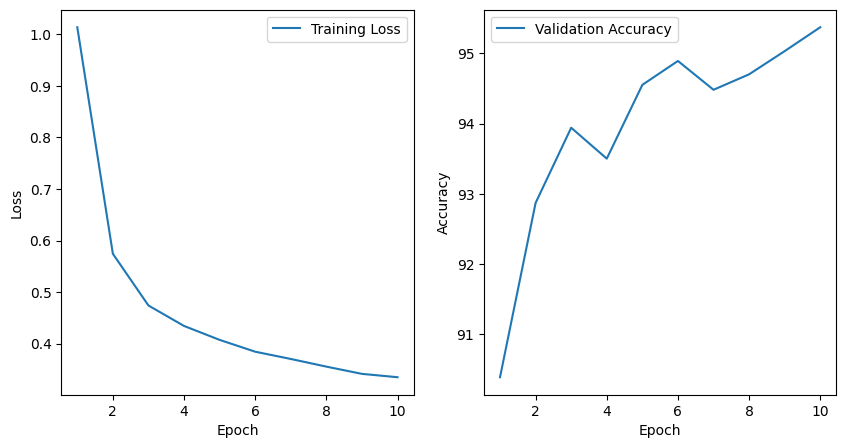

Testing Accuracy: 0.96%
F1 Score: 0.9566


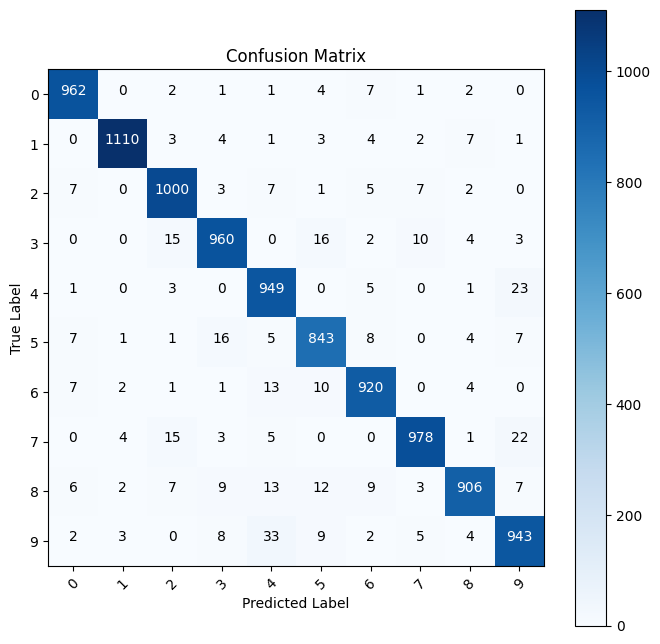

In [1]:
import torch
import torch.nn as nn
import torch.optim as optim
import torchvision
from torchvision import transforms, datasets
from torch.utils.data import DataLoader, random_split
import numpy as np
import matplotlib.pyplot as plt
from sklearn.metrics import confusion_matrix, f1_score, accuracy_score
import itertools

# Step 1: Data loading and normalization
def loadDataset(dataset_path, train_size, valid_size, test_size, batch_size, shuffle=True):
    transform = transforms.Compose([
        transforms.Resize((28, 28)),
        transforms.ToTensor(),
        transforms.Normalize((0.5,), (0.5,))
    ])

    dataset = datasets.MNIST(root=dataset_path, train=True, download=True, transform=transform)
    test_dataset = datasets.MNIST(root=dataset_path, train=False, download=True, transform=transform)

    # Split the dataset into training, validation, and testing sets
    total_size = len(dataset)
    train_set, valid_set, _ = random_split(dataset, [train_size, valid_size, total_size - train_size - valid_size])

    train_loader = DataLoader(train_set, batch_size=batch_size, shuffle=shuffle)
    valid_loader = DataLoader(valid_set, batch_size=batch_size, shuffle=False)
    test_loader = DataLoader(test_dataset, batch_size=batch_size, shuffle=False)

    return train_loader, valid_loader, test_loader

# Step 2: Initialize Network
def init_network(no_of_layers, input_dim, neurons_per_layer, dropout):
    layers = []
    prev_layer_dim = input_dim

    for neurons in neurons_per_layer:
        layers.append(nn.Linear(prev_layer_dim, neurons))
        layers.append(nn.ReLU())
        layers.append(nn.Dropout(dropout))
        prev_layer_dim = neurons

    layers.append(nn.Linear(prev_layer_dim, 10))
    net = nn.Sequential(*layers)

    return net

# Step 3: Training
def train(net, train_loader, valid_loader, learning_rate, training_epochs, loss_func, optimizer):
    device = torch.device("cpu")
    net.to(device)

    criterion = loss_func()
    optimizer = optimizer(net.parameters(), lr=learning_rate)

    loss_array = []
    accuracy_array = []

    for epoch in range(training_epochs):
        net.train()
        total_loss = 0.0
        correct = 0
        total = 0

        for inputs, labels in train_loader:
            inputs, labels = inputs.to(device), labels.to(device)
            optimizer.zero_grad()
            outputs = net(inputs.view(-1, 28 * 28))
            loss = criterion(outputs, labels)
            loss.backward()
            optimizer.step()

            total_loss += loss.item()
            _, predicted = torch.max(outputs.data, 1)
            total += labels.size(0)
            correct += (predicted == labels).sum().item()

        # Calculate accuracy and loss on validation set
        net.eval()
        valid_correct = 0
        valid_total = 0
        valid_loss = 0.0

        with torch.no_grad():
            for inputs, labels in valid_loader:
                inputs, labels = inputs.to(device), labels.to(device)
                outputs = net(inputs.view(-1, 28 * 28))
                valid_loss += criterion(outputs, labels).item()
                _, valid_predicted = torch.max(outputs.data, 1)
                valid_total += labels.size(0)
                valid_correct += (valid_predicted == labels).sum().item()

        loss_array.append(total_loss / len(train_loader))
        accuracy_array.append(100.0 * valid_correct / valid_total)

        print(f"Epoch [{epoch + 1}/{training_epochs}] Loss: {total_loss / len(train_loader):.4f} "
              f"Accuracy: {100.0 * valid_correct / valid_total:.2f}%")

    return net, loss_array, accuracy_array

# Step 4: Save Network
def save_network(net, filename):
    torch.save(net.state_dict(), filename)

# Step 5: Load Network
def load_network(filename, input_dim, neurons_per_layer):
    net = init_network(len(neurons_per_layer), input_dim, neurons_per_layer, 0.2)
    net.load_state_dict(torch.load(filename))
    return net

# Step 6: Testing
def test(net, test_loader):
    device = torch.device("cpu")
    net.to(device)

    net.eval()
    predictions = []
    targets = []

    with torch.no_grad():
        for inputs, labels in test_loader:
            inputs, labels = inputs.to(device), labels.to(device)
            outputs = net(inputs.view(-1, 28 * 28))
            _, predicted = torch.max(outputs.data, 1)

            predictions.extend(predicted.cpu().numpy())
            targets.extend(labels.cpu().numpy())

    return predictions, targets

# Step 7: Visualize Results
def plot_loss_accuracy_curves(loss_array, accuracy_array):
    plt.figure(figsize=(10, 5))
    plt.subplot(1, 2, 1)
    plt.plot(range(1, len(loss_array) + 1), loss_array, label='Training Loss')
    plt.xlabel('Epoch')
    plt.ylabel('Loss')
    plt.legend()

    plt.subplot(1, 2, 2)
    plt.plot(range(1, len(accuracy_array) + 1), accuracy_array, label='Validation Accuracy')
    plt.xlabel('Epoch')
    plt.ylabel('Accuracy')
    plt.legend()

    plt.show()

def plot_confusion_matrix(y_true, y_pred, classes):
    cm = confusion_matrix(y_true, y_pred)
    plt.figure(figsize=(8, 8))
    plt.imshow(cm, interpolation='nearest', cmap=plt.cm.Blues)
    plt.title('Confusion Matrix')
    plt.colorbar()
    tick_marks = np.arange(len(classes))
    plt.xticks(tick_marks, classes, rotation=45)
    plt.yticks(tick_marks, classes)

    fmt = 'd'
    thresh = cm.max() / 2.
    for i, j in itertools.product(range(cm.shape[0]), range(cm.shape[1])):
        plt.text(j, i, format(cm[i, j], fmt), horizontalalignment="center",
                 color="white" if cm[i, j] > thresh else "black")

    plt.ylabel('True Label')
    plt.xlabel('Predicted Label')
    plt.show()

# Step 8: Main Function
def main(dataset_path, train_size, valid_size, test_size, no_of_layers, neurons_per_layer, loss_func, optimizer,
         batch_size, learning_rate, use_gpu=False, dropout=0.2, is_training=True, visualize_results=False, training_epochs=10):

    train_loader, valid_loader, test_loader = loadDataset(dataset_path, train_size, valid_size, test_size, batch_size)

    if is_training:
        net = init_network(no_of_layers, 784, neurons_per_layer + [10], dropout)
        print("Initialized Network:")
        for i, layer in enumerate(net):
            if isinstance(layer, nn.Linear):
                print(f"Size of net({i + 1}).w = {layer.weight.shape[0]}x{layer.weight.shape[1]}")
                print(f"Size of net({i + 1}).b = {layer.bias.shape[0]}")

        net, loss_array, accuracy_array = train(net, train_loader, valid_loader, learning_rate, training_epochs, loss_func, optimizer)
        save_network(net, "trained_model.pth")

        if visualize_results:
            plot_loss_accuracy_curves(loss_array, accuracy_array)
    else:
        net = load_network("trained_model.pth", 784, neurons_per_layer + [10])

    # Step 6: Testing
    predictions, targets = test(net, test_loader)
    accuracy = accuracy_score(targets, predictions)
    f1 = f1_score(targets, predictions, average='macro')

    print(f"Testing Accuracy: {accuracy:.2f}%")
    print(f"F1 Score: {f1:.4f}")

    if visualize_results:
        plot_confusion_matrix(targets, predictions, classes=[str(i) for i in range(10)])

# Example usage:
main(dataset_path='./MNIST_data', train_size=50000, valid_size=10000, test_size=10000, no_of_layers=2,
     neurons_per_layer=[100, 50], loss_func=nn.CrossEntropyLoss, optimizer=optim.Adam,
     batch_size=64, learning_rate=0.001, is_training=True, visualize_results=True, training_epochs=10)

